In [10]:
import duckdb
import pandas

con = duckdb.connect(database='../../data/foot-data-Transfermarkt.duckdb', read_only=True)

df_season_overview = con.execute("SELECT pac.*\
            FROM  player_actions_cards pac \
            ORDER BY season ASC, home ASC").fetchdf()

df_season_overview.head()

,season,player_id,player_name,yellow_cards,red_cards,goals,assists,minutes_played,home_club_id,club_home_name,away_club_id,club_away_name,player_club_id,home
0,2013,145602,Nicolás Castillo,0,0,1,0,90,28643,Waasland Beveren,2282,Fc Brugge,2282,False
1,2013,96454,Maxime Lestienne,0,0,0,0,15,28643,Waasland Beveren,2282,Fc Brugge,2282,False
2,2013,111061,Alassane També,0,0,0,0,90,3508,Sv Zulte Waregem,601,Kv Kortrijk,601,False
3,2013,18514,Giuseppe Rossini,0,0,0,0,14,3057,Standard Luttich,172,Rsc Charleroi,172,False
4,2013,56789,Lynel Kitambala,0,0,0,0,76,3057,Standard Luttich,172,Rsc Charleroi,172,False


In [27]:
df_clubs_home = con.execute("SELECT home_club_id, club_home_name, season, \
            SUM(yellow_cards) as yc, SUM(red_cards) as rc, \
            SUM(goals) as goals, SUM(assists) as assists \
            FROM  player_actions_cards \
            WHERE home = 'True' \
            GROUP BY home_club_id, club_home_name, season\
            ").fetchdf()

df_clubs_home.head()

,home_club_id,club_home_name,season,yc,rc,goals,assists
0,3057,Standard Luttich,2014,23.0,0.0,23.0,21.0
1,2282,Fc Brugge,2014,21.0,1.0,36.0,29.0
2,520,Cercle Brugge,2014,29.0,1.0,11.0,8.0
3,58,Rsc Anderlecht,2013,1.0,0.0,3.0,3.0
4,58,Rsc Anderlecht,2014,17.0,1.0,25.0,21.0


In [70]:
df_clubs_away = con.execute("SELECT away_club_id, club_away_name, season, \
            SUM(yellow_cards) as yc, SUM(red_cards) as rc, \
            SUM(goals) as goals, SUM(assists) as assists \
            FROM  player_actions_cards \
            WHERE home = 'False' \
            AND away_club_id IN (\
                SELECT away_club_id FROM (SELECT away_club_id, COUNT(DISTINCT(season)) dst\
                FROM player_actions_cards\
                GROUP BY away_club_id\
                HAVING dst >7)\
            ) \
            GROUP BY away_club_id, club_away_name, season\
            ORDER BY season \
            ").fetchdf()
print(df_clubs_away)

     away_club_id club_away_name  season    yc   rc  goals  assists
0            2282      Fc Brugge    2013   1.0  0.0    2.0      2.0
1             601    Kv Kortrijk    2013   2.0  0.0    0.0      0.0
2             172  Rsc Charleroi    2013   3.0  0.0    0.0      0.0
3            1184       Krc Genk    2013   2.0  0.0    1.0      1.0
4            2861    Kv Oostende    2013   4.0  0.0    0.0      0.0
..            ...            ...     ...   ...  ...    ...      ...
115           354    Kv Mechelen    2022  39.0  1.0   11.0      7.0
116           475  Vv St Truiden    2022  32.0  2.0   15.0     14.0
117           601    Kv Kortrijk    2022  34.0  0.0   20.0     12.0
118           172  Rsc Charleroi    2022  40.0  1.0   20.0     19.0
119          2861    Kv Oostende    2022  29.0  2.0   17.0     11.0

[120 rows x 7 columns]


In [61]:
df_test = con.execute("SELECT away_club_id, club_away_name, COUNT(DISTINCT(season)) dst\
                       FROM player_actions_cards\
                       GROUP BY away_club_id, club_away_name\
                       HAVING dst >6 \
").fetchdf()
print(df_test)

    away_club_id        club_away_name  dst
0           3057      Standard Luttich    9
1            157              Kaa Gent   10
2           3508      Sv Zulte Waregem    9
3            354           Kv Mechelen    9
4            601           Kv Kortrijk   10
5           2282             Fc Brugge   10
6             58        Rsc Anderlecht    9
7           2861           Kv Oostende   10
8            520         Cercle Brugge    7
9          28643      Waasland Beveren    7
10          1184              Krc Genk   10
11         29228  Royal Excel Mouscron    8
12           172         Rsc Charleroi   10
13          1245             Kas Eupen    8
14           475         Vv St Truiden    8


In [71]:
years = pandas.unique(df_clubs_away['season'])
print(years)
df_clubs_away['yc']

[2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


0       1.0
1       2.0
2       3.0
3       2.0
4       4.0
       ... 
115    39.0
116    32.0
117    34.0
118    40.0
119    29.0
Name: yc, Length: 120, dtype: float64

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Clubs present for more than 6 years: Yellow cards per season')

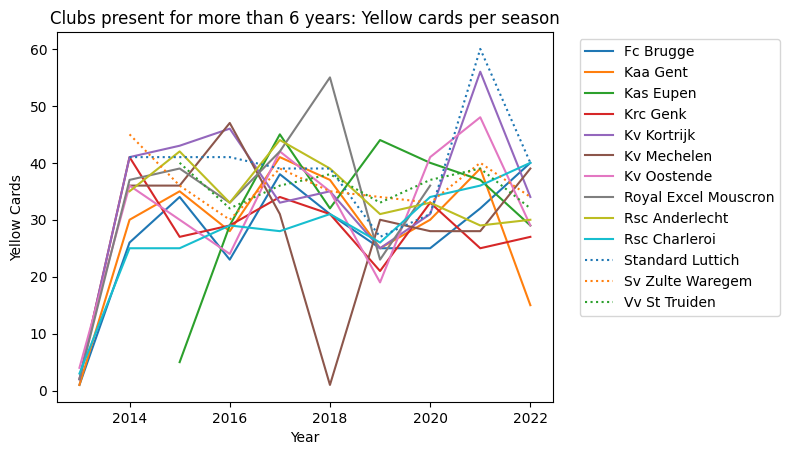

In [72]:
dotted=-10
for key, grp in df_clubs_away.groupby(['club_away_name']):
    linestyle = 'solid' if dotted < 0 else 'dotted'
    linestyle = 'dashed' if dotted > 10 else linestyle
    dotted = dotted +1
    plt.plot(grp['season'], grp['yc'], label=key[0], linestyle=linestyle)
plt.xlabel('Year')
plt.ylabel('Yellow Cards')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title('Clubs present for more than 7 years: Yellow cards per season')